KNN-Classifier

In [152]:
%pip install fast-ml

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [153]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder

train_dataset = pd.read_csv('updated_train.csv')
label_encoder = LabelEncoder()
train_dataset['Sex'] = label_encoder.fit_transform(train_dataset['Sex'])

In [154]:
import numpy as np 

# hyperparameter optimization
from sklearn.model_selection import GridSearchCV
from fast_ml.model_development import train_valid_test_split
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(train_dataset, target = 'Survived', 
                                                                            train_size=0.7, valid_size=0.15, test_size=0.15)


In [155]:
from itertools import product
def generate_prior_combinations(num_combinations=10):
    """
    Generate combinations of prior probabilities for a binary classification problem.

    Parameters:
    - num_combinations (int): Number of combinations to generate.

    Returns:
    - List of tuples, where each tuple represents a combination of prior probabilities.
    """
    # Ensure that num_combinations is a positive integer
    num_combinations = max(1, int(num_combinations))

    # Generate all possible combinations of prior probabilities
    prior_combinations = list(product(np.linspace(0, 1, num_combinations), repeat=2))

    # Filter out combinations where the sum is not 1 (valid probabilities)
    prior_combinations = [prior for prior in prior_combinations if sum(prior) == 1]

    return prior_combinations

In [156]:
from sklearn.naive_bayes import GaussianNB

# Training the model on the training dataset
gnb = GaussianNB()
gnb.fit(X_train,y_train)
y_pred = gnb.predict(X_test)

# Fine tuning the model on the validation dataset
grid_params = {
    "var_smoothing": np.logspace(0,-9,num=100),
    "priors": generate_prior_combinations(30)    
    }

gs = GridSearchCV(gnb, param_grid=grid_params, scoring=["accuracy","f1","precision","recall","roc_auc"],cv=10,n_jobs=-1,refit="f1" )
gs.fit(X_valid, y_valid)

y_pred = gs.predict(X_test)


# import sklearn.metrics
# sklearn.metrics.get_scorer_names()

In [169]:
gs.best_score_

0.7616450216450217

In [158]:
from sklearn.metrics import accuracy_score
print(f"Naive Bayes Score after hyperparameter tuning (on testing): {accuracy_score(y_test,y_pred)}")

Naive Bayes Score after hyperparameter tuning (on testing): 0.7835820895522388


In [159]:
# precesion score
from sklearn.metrics import precision_score
print(precision_score(y_test, y_pred, average='macro'))

0.7668926553672316


In [160]:
# Recall Score
from sklearn.metrics import recall_score
print(recall_score(y_test, y_pred, average='macro'))

0.7982323232323232


In [161]:
# F1-Score
from sklearn.metrics import f1_score
print(f1_score(y_test, y_pred, average='macro'))

0.7713445130920858


In [162]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(true_y, y_prob):

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 

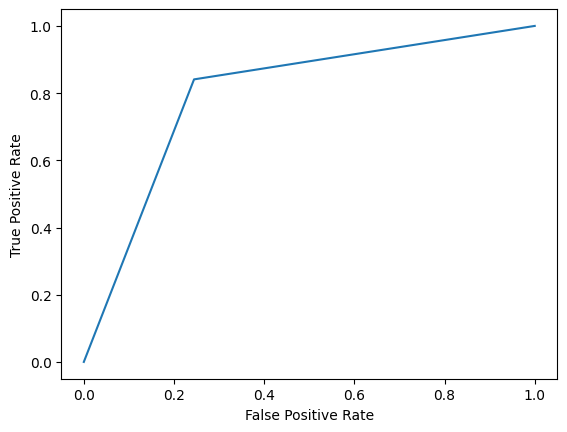

Bayes Classifier AUC score: 0.7982323232323232


In [163]:
# ROC/AUC Curves

plot_roc_curve(y_test, y_pred)
plt.show()
print(f'Bayes Classifier AUC score: {roc_auc_score(y_test, y_pred)}') 

In [164]:
gs.cv_results_

{'mean_fit_time': array([0.00381212, 0.00396628, 0.00381839, ..., 0.00421007, 0.00376873,
        0.00437391]),
 'std_fit_time': array([0.00079731, 0.00172369, 0.00097813, ..., 0.0005601 , 0.00055133,
        0.0006307 ]),
 'mean_score_time': array([0.01407158, 0.01793067, 0.01670671, ..., 0.02026455, 0.01736224,
        0.0164891 ]),
 'std_score_time': array([0.00190539, 0.00441641, 0.00318466, ..., 0.00936378, 0.00389971,
        0.00194162]),
 'param_priors': masked_array(data=[(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), ..., (1.0, 0.0),
                    (1.0, 0.0), (1.0, 0.0)],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'param_var_smoothing': masked_array(data=[1.0, 0.8111308307896871, 0.657933224657568, ...,
                    1.519911082952933e-09, 1.2328467394420635e-09, 1e-09],
              mask=[False, False, False, ..., False, False, False],
        fill_value='?',
             dtype=object),
 'params'

#### Visualizing accuracy changes

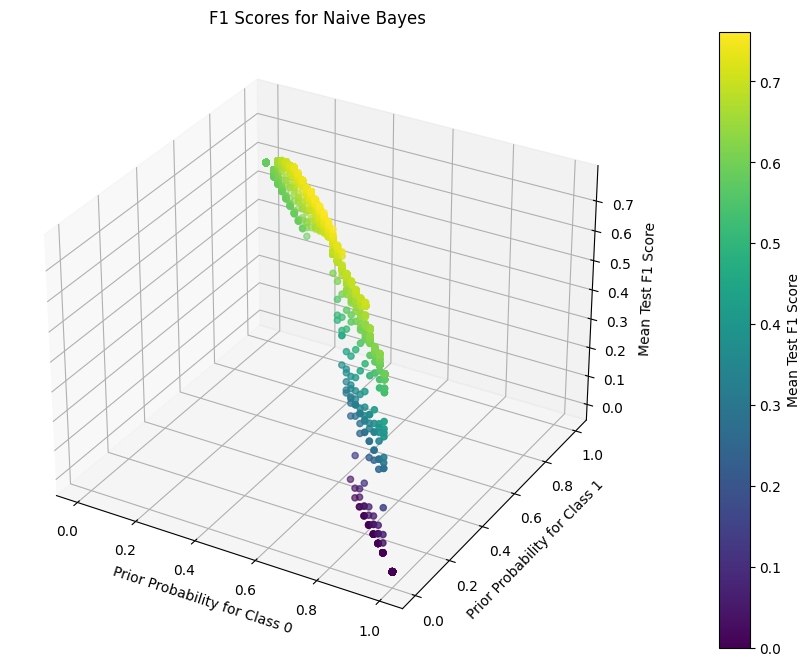

In [165]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


# Extract the F1 scores, prior probabilities, and hyperparameters from the cv_results_
f1_scores = gs.cv_results_['mean_test_f1']
params = gs.cv_results_['params']

# Extract the values for each hyperparameter and prior probabilities
prior_class_0_values = [param['priors'][0] for param in params]
prior_class_1_values = [param['priors'][1] for param in params]

# Create a 3D scatter plot to visualize the F1 scores
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for F1 scores as a function of prior probabilities
sc = ax.scatter(prior_class_0_values, prior_class_1_values, f1_scores, c=f1_scores, cmap='viridis', marker='o')

ax.set_xlabel('Prior Probability for Class 0')
ax.set_ylabel('Prior Probability for Class 1')
ax.set_zlabel('Mean Test F1 Score')

plt.title('F1 Scores for Naive Bayes')

# Add a colorbar to the right of the plot
cbar = fig.colorbar(sc, ax=ax, pad=0.1, aspect=20)
cbar.set_label('Mean Test F1 Score')

plt.show()


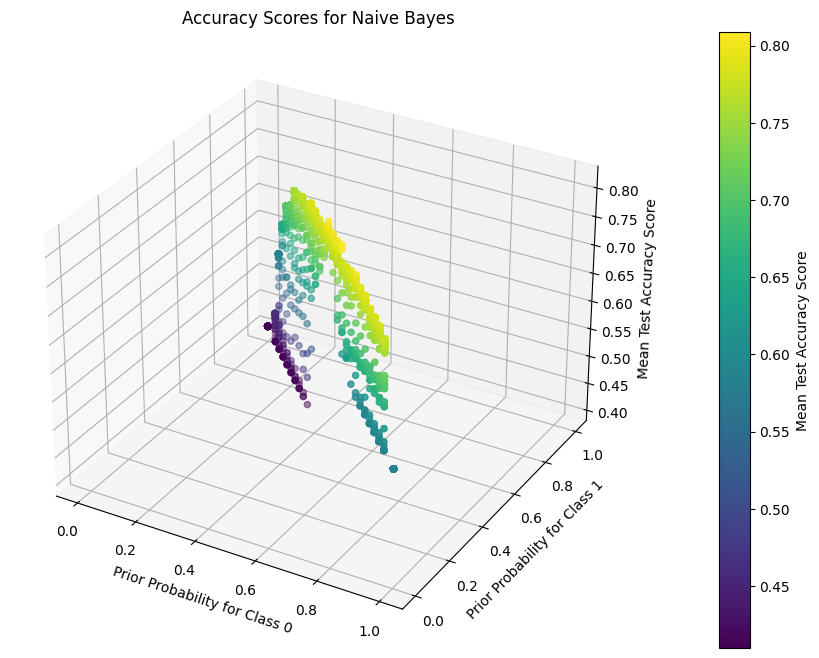

In [166]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Extract the F1 scores, prior probabilities, and hyperparameters from the cv_results_
f1_scores = gs.cv_results_['mean_test_accuracy']
params = gs.cv_results_['params']

# Extract the values for each hyperparameter and prior probabilities
prior_class_0_values = [param['priors'][0] for param in params]
prior_class_1_values = [param['priors'][1] for param in params]

# Create a 3D scatter plot to visualize the F1 scores
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for F1 scores as a function of prior probabilities
sc = ax.scatter(prior_class_0_values, prior_class_1_values, f1_scores, c=f1_scores, cmap='viridis', marker='o')

ax.set_xlabel('Prior Probability for Class 0')
ax.set_ylabel('Prior Probability for Class 1')
ax.set_zlabel('Mean Test Accuracy Score')

plt.title('Accuracy Scores for Naive Bayes')

# Add a colorbar to the right of the plot
cbar = fig.colorbar(sc, ax=ax, pad=0.1, aspect=20)
cbar.set_label('Mean Test Accuracy Score')

plt.show()


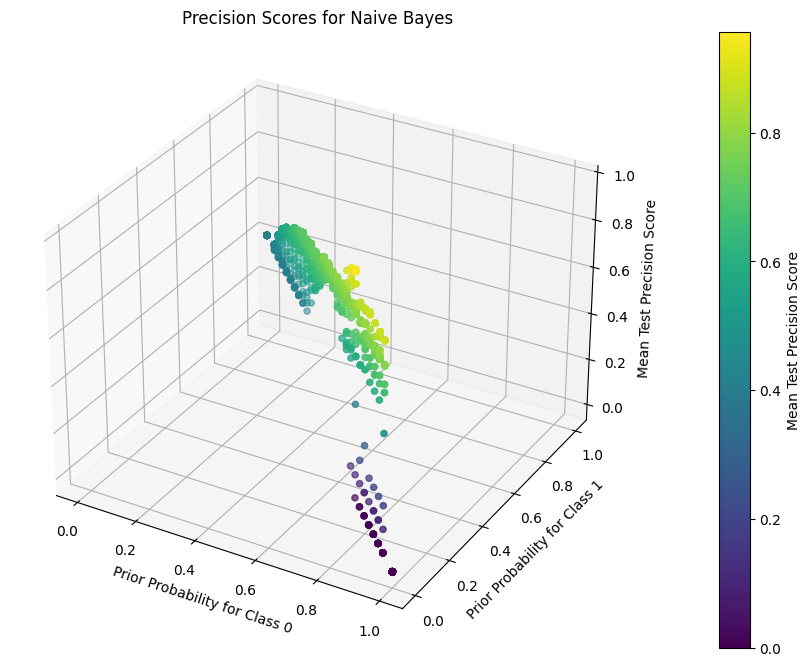

In [167]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D


# Extract the F1 scores, prior probabilities, and hyperparameters from the cv_results_
f1_scores = gs.cv_results_['mean_test_precision']
params = gs.cv_results_['params']

# Extract the values for each hyperparameter and prior probabilities
prior_class_0_values = [param['priors'][0] for param in params]
prior_class_1_values = [param['priors'][1] for param in params]

# Create a 3D scatter plot to visualize the F1 scores
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for F1 scores as a function of prior probabilities
sc = ax.scatter(prior_class_0_values, prior_class_1_values, f1_scores, c=f1_scores, cmap='viridis', marker='o')

ax.set_xlabel('Prior Probability for Class 0')
ax.set_ylabel('Prior Probability for Class 1')
ax.set_zlabel('Mean Test Precision Score')

plt.title('Precision Scores for Naive Bayes')

# Add a colorbar to the right of the plot
cbar = fig.colorbar(sc, ax=ax, pad=0.1, aspect=20)
cbar.set_label('Mean Test Precision Score')

plt.show()


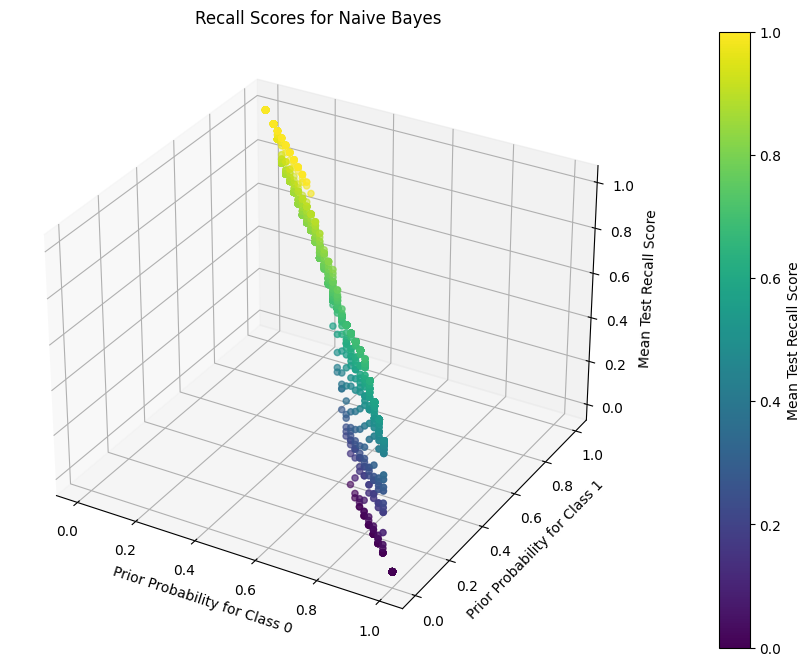

In [168]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'grid_search' is your GridSearchCV object

# Extract the F1 scores, prior probabilities, and hyperparameters from the cv_results_
f1_scores = gs.cv_results_['mean_test_recall']
params = gs.cv_results_['params']

# Extract the values for each hyperparameter and prior probabilities
prior_class_0_values = [param['priors'][0] for param in params]
prior_class_1_values = [param['priors'][1] for param in params]

# Create a 3D scatter plot to visualize the F1 scores
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for F1 scores as a function of prior probabilities
sc = ax.scatter(prior_class_0_values, prior_class_1_values, f1_scores, c=f1_scores, cmap='viridis', marker='o')

ax.set_xlabel('Prior Probability for Class 0')
ax.set_ylabel('Prior Probability for Class 1')
ax.set_zlabel('Mean Test Recall Score')

plt.title('Recall Scores for Naive Bayes')

# Add a colorbar to the right of the plot
cbar = fig.colorbar(sc, ax=ax, pad=0.1, aspect=20)
cbar.set_label('Mean Test Recall Score')

plt.show()
